# aSPEM Experiment : analysis



TODO: clean-up garder blocs indep full R

TODO: moulinette statistique ? https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test https://en.wikipedia.org/wiki/Earth_mover%27s_distance

TODO: https://stackoverflow.com/questions/37008112/matplotlib-plotting-histogram-plot-just-above-scatter-plot

TODO: tester qu'à chaque pause, l'agent se réinitialise à $\hat{p}=.5$

In [1]:
%run 0_parameters.ipynb


WELCOME



In [2]:
import pickle
import glob
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [4]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

# find_h_with_MI

In [5]:
def mask_nan(h_va, h_bet, r_va, r_bet) :
    r_va = np.ma.masked_array(r_va, mask=np.isnan(h_bet)).compressed()
    h_va = np.ma.masked_array(h_va, mask=np.isnan(h_bet)).compressed()

    r_bet = np.ma.masked_array(r_bet, mask=np.isnan(h_bet)).compressed()
    h_bet = np.ma.masked_array(h_bet, mask=np.isnan(h_bet)).compressed()

    r_bet = np.ma.masked_array(r_bet, mask=np.isnan(h_va)).compressed()
    h_bet = np.ma.masked_array(h_bet, mask=np.isnan(h_va)).compressed()
    
    r_va = np.ma.masked_array(r_va, mask=np.isnan(h_va)).compressed()
    h_va = np.ma.masked_array(h_va, mask=np.isnan(h_va)).compressed()
    
    return h_va, h_bet, r_va, r_bet

In [6]:
def maxx_pourcentage(r_, pourcentage) :
    maxx=None
    for round_ in list(reversed(np.arange(5))) :
        if maxx is None :
            for x in range(len(r_)) :
                if np.round(r_[x], round_)==np.round(pourcentage*np.max(r_), round_) :
                    maxx=x
    return maxx

In [7]:
def print_stat(h) :
    from scipy import stats
    
    print('\n\t\t\tmannwhitneyu', '\tkruskal', '\t\tks_2samp', sep='')
    print('\t\t\t','-'*12, '\t', '-'*7, '\t\t', '-'*8, sep='')
    
    def stata(h1, h2) :
        man = stats.mannwhitneyu(h1, h2).pvalue
        kr = stats.kruskal(h1, h2).pvalue
        ks = stats.ks_2samp(h1, h2).pvalue
        print('%.4f'%man, '%.4f'%kr, '%.4f'%ks, sep='\t\t')
              #'\nwasserstein_distance (Earth movers distance) : ',
              #stats.wasserstein_distance(h['F'], h['M'], u_weights=r['F'], v_weights=r['M']), sep='')
        return man, kr, ks
    
    
    list_signi = []
    
    
    for b1 in range(2) :
        for b2 in range(1, 3) :
            if b1!=b2 :
                print('BLOCK %s vs %s'%(b1,b2), end=' :\t\t')
                man, kr, ks = stata(h['b'][b1], h['b'][b2])
                for s in [man, kr, ks] :
                    if s < 0.05 : list_signi.append('B %s-%s'%(b1,b2)) ; break
    
    
    print('\nSignificatif :', list_signi)
    return list_signi

In [8]:
suj = ['AM', 'BMC', 'CS', 'DC', 'FM', 'IP', 'LB', 'OP', 'RS', 'SR',  'TN', 'YK']

In [9]:
fig_width_f = fig_width/2
def plot_fig(recording, max_tau=None, coupe=[1/500, 1/200], pourcentage=None, ls=None,c_ls=None, mean='mean') :
    
    from matplotlib.patches import Polygon
    
    Full = e.Full_list(modes_bcp=[])
    list_h = recording['list_h'][:max_tau]
    #COLOR = ['b', 'r', 'k', 'g', 'm', 'c', 'gold', 'darkred', 'peru', 'silver', 'plum', 'olivedrab']
    c_block = ['olive', 'peru', 'brown']
    
    
    fig = plt.figure(figsize=(fig_width_f,fig_width_f))
    import matplotlib.gridspec as gridspec

    gs = gridspec.GridSpec(5, 5, figure=fig, left=0.1, bottom=0.1, right=1, top=1)
    ax_ = plt.subplot(gs[1:, :4])
    ax_x, ax_y  = plt.subplot(gs[0, :4]), plt.subplot(gs[1:, 4])
    
    
    # DECO
    #---------------------------------------------------------------
    lim = (min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
    ax_.set_xlim(lim)     ; ax_.set_ylim(lim)
    ax_.set_xscale("log") ; ax_.set_yscale("log")
    
    ax_x.tick_params('y',colors='dimgrey') ; ax_y.tick_params('x',colors='dimgrey')
    ax_xC, ax_yC = ax_x.twinx(), ax_y.twiny()
    
    lim = (np.log(min(list_h)-min(list_h)/10), np.log(max(list_h)+max(list_h)/10))
    for a in [ax_x, ax_xC] : a.set_xlim(lim) ; a.set_xticks(())
    for a in [ax_y, ax_yC] : a.set_ylim(lim) ; a.set_yticks(())
    
    # LABEL
    ax_.set_xlabel('h$_{va}$', fontsize=t_label) ; ax_.set_ylabel('h$_{bet}$', labelpad=-20, fontsize=t_label)
    opt = dict(fontsize=t_label/2.7)
    ax_xC.set_ylabel('cumulative', va='bottom', labelpad=0, rotation=270, **opt)
    ax_yC.set_xlabel('cumulative', va='bottom',labelpad=5, **opt) 
    opt['color'] = 'dimgrey'
    ax_x.set_ylabel('density of h$_{va}$', **opt) ; ax_y.set_xlabel('density of h$_{bet}$', **opt) 
    
    for a in [ax_, ax_x, ax_xC, ax_y, ax_yC] : a.set_title('', fontsize=0)
    
    # tick
    ax_.tick_params(labelsize=t_label/2.7, length=7, which='major') ; ax_.tick_params(length=5, which='minor')
    
    opt = dict(labelsize=t_label/2.7)
    ax_x.tick_params(**opt)                ; ax_y.tick_params(**opt)
    ax_xC.tick_params(**opt)               ; ax_yC.tick_params(pad=0.01, **opt)
    ax_x.set_yticks(())                    ; ax_y.set_xticks(()) #(0,2,4,6))
    ax_xC.set_yticks((0,0.5,1))            ; ax_yC.set_xticks((0,0.5,1))
    ax_xC.set_yticklabels(('0','0.5','1')) ; ax_yC.set_xticklabels(('0','0.5','1'))
    
    #---------------------------------------------------------------
    h_va, h_bet, r_va, r_bet = {}, {}, {}, {}
    for l in [h_va, h_bet, r_va, r_bet] : l['full'], l['b'] = [], [[],[],[]]
        
    #---------------------------------------------------------------
    for num, s in enumerate(suj) :
        
        print(s, end=' ')

        h_va_s, h_bet_s, r_va_s, r_bet_s = [], [], [], []
        for d, c in enumerate(range(0, 3*200-150, 200)) :
            r_va_d, r_bet_d = recording['r_va'][s][d][:max_tau], recording['r_bet'][s][d][:max_tau]

            if pourcentage is not None :
                #pourcentage
                #-----------------------------------------------------------------------
                if np.argmax(r_va_d)==len(list_h)-1 :
                    maxx = maxx_pourcentage(r_va_d, pourcentage)
                    r_va_s.append(r_va_d[maxx]) ; h_va_s.append(list_h[maxx])
                else : r_va_s.append(np.max(r_va_d)) ; h_va_s.append(list_h[np.argmax(r_va_d)])

                if np.argmax(r_bet_d)==len(list_h)-1 :
                    maxx = maxx_pourcentage(r_bet_d, pourcentage)
                    r_bet_s.append(r_bet_d[maxx])   ; h_bet_s.append(list_h[maxx])
                else : r_bet_s.append(np.max(r_bet_d)) ; h_bet_s.append(list_h[np.argmax(r_bet_d)])
                #-----------------------------------------------------------------------
            else :
                r_va_s.append(np.max(r_va_d))   ; h_va_s.append(list_h[np.argmax(r_va_d)])
                r_bet_s.append(np.max(r_bet_d)) ; h_bet_s.append(list_h[np.argmax(r_bet_d)])
                
            h_va['b'][d].append(h_va_s[d]) ; h_bet['b'][d].append(h_bet_s[d])
            r_va['b'][d].append(r_va_s[d]) ; r_bet['b'][d].append(r_bet_s[d])
        
        #-----------------------------------------------------------------------
        # TRIANGLE
        tritri = np.array([[h_va_s[y], h_bet_s[y]] for y in range(len(h_va_s))])
        popo = Polygon(tritri, edgecolor=c_ls[num] if c_ls is not None else 'k',
                       alpha=1 if c_ls is not None else 0.4, lw=1,
                       ls=ls[num] if ls is not None else '-', facecolor='none') # color=COLOR[num]  
        ax_.add_artist(popo)
        
        #-----------------------------------------------------------------------           
        opt = dict(alpha=0.6, lw=0, edgecolors='k') # c=COLOR[num], lw=3
        if s in ['TN', 'LB'] :
            ax_.scatter(h_va_s[:1], h_bet_s[:1], s=(np.array(r_va_s[:1])*np.array(r_bet_s[:1]))*1000,
                        marker='*', c=c_block[:1], zorder=100, lw=0.1, edgecolors='k')
        else :
            ax_.scatter(h_va_s[:1], h_bet_s[:1], s=(np.array(r_va_s[:1])*np.array(r_bet_s[:1]))*600,
                        c=c_block[:1], zorder=50, **opt)

        ax_.scatter(h_va_s[1:], h_bet_s[1:], s=(np.array(r_va_s[1:])*np.array(r_bet_s[1:]))*600,
                    c=c_block[1:], zorder=50, **opt)
        
        #-----------------------------------------------------------------------
        h_va['full'].extend(h_va_s) ; h_bet['full'].extend(h_bet_s)
        r_va['full'].extend(r_va_s) ; r_bet['full'].extend(r_bet_s)
    
    h_va['full'], h_bet['full'], r_va['full'], r_bet['full'] = mask_nan(h_va['full'], h_bet['full'], r_va['full'], r_bet['full'])
    r_va['full'], r_bet['full'] = np.array(r_va['full']), np.array(r_bet['full'])

    #--------------------------------------------------------------------------------------------
    # HISTOGRAMME
    #--------------------------------------------------------------------------------------------
    opt = dict(range=(np.log(min(list_h)), np.log(max(list_h))), bins=20)#, alpha=0.3)
    opt_c = dict(range=(np.log(min(list_h)-min(list_h)/9), np.log(max(list_h)+max(list_h)/9)),
                 bins=len(list_h), cumulative=True, histtype='step', align='mid', lw=2, density=True)
    
    # hist VA
    #--------------------------------------------------------------------
    for a, o, c in zip([ax_x, ax_xC], [opt, opt_c], ['dimgrey', 'k']) :
        a.hist(np.log(h_va['full']), weights=r_va['full'], color=c, label='Full',
               alpha=0.2 if o==opt else 1, **o)
        a.hist([np.log(h_va['b'][0]), np.log(h_va['b'][1]), np.log(h_va['b'][2])],
               weights=[r_va['b'][0], r_va['b'][1], r_va['b'][2]],
               color=c_block, label=['block 1', 'block 2', 'block 3'],
               alpha=0.6 if o==opt else 1, **o)
    
    # hist BET
    #--------------------------------------------------------------------
    opt['orientation'], opt_c['orientation'] = "horizontal", "horizontal"
    for a, o, c in zip([ax_y, ax_yC], [opt, opt_c], ['dimgrey', 'k']) :
        a.hist(np.log(h_bet['full']), weights=r_bet['full'], color=c, label='Full',
               alpha=0.2 if o==opt else 1, **o)
        a.hist([np.log(h_bet['b'][0]), np.log(h_bet['b'][1]), np.log(h_bet['b'][2])],
               weights=[r_bet['b'][0], r_bet['b'][1], r_bet['b'][2]],
               color=c_block, label=['block 1', 'block 2', 'block 3'],
               alpha=0.6 if o==opt else 1, **o)
    #--------------------------------------------------------------------
    opt_l = dict(fontsize=t_label/2.7, framealpha=0, handlelength=0.6, handletextpad=0.2)
    ax_y.legend(loc=9 ,**opt_l) ; ax_x.legend(loc=7, **opt_l)
    #--------------------------------------------------------------------------------------------
    
    # lines
    #--------------------------------------------------------------------------------------------
    ax_.plot(np.arange(-10,10), np.arange(-10,10), '-k', alpha=0.5, lw=1)
    opt=dict(colors='teal', linestyles='-', alpha=0.7, linewidth=1.5)
    ax_.vlines(0.025, -10, 10, **opt) ; ax_.hlines(0.025, -10, 10, **opt)
    ax_xC.vlines(np.log(0.025), 0, 1, **opt) ; ax_yC.hlines(np.log(0.025), 0, 1, **opt)
    
    
    
    if mean=='mean' : mimi_va, mimi_bet = np.nanmean(h_va['full']), np.nanmean(h_bet['full'])
    elif mean=='median' : mimi_va, mimi_bet = np.nanmedian(h_va['full']), np.nanmedian(h_bet['full'])
    elif mean=='mean_pond' :
        mimi_va = np.average(h_va['full'], weights=(1/(1-r_va['full'])))
        mimi_bet = np.average(h_bet['full'], weights=(1/(1-r_bet['full'])))
    
    opt=dict(colors='k', alpha=0.8, lw=1.5, linestyles=(3.5,[9, 3, 9, 3]))
    ax_.vlines(mimi_va, 0, 10, **opt) ; ax_.hlines(mimi_bet, 0, 10, **opt)
    ax_xC.vlines(np.log(mimi_va), 0, 1, **opt) ; ax_yC.hlines(np.log(mimi_bet), 0, 1, **opt)
    
    
    opt=dict(alpha=0.7, lw=1.5, linestyles=(3.5,[9, 3, 9, 3]))
    
    for b, c in enumerate(c_block) :
        opt['colors']=c
        
        if mean=='mean' : mimi_va, mimi_bet = np.nanmean(h_va['b'][b]), np.nanmean(h_bet['b'][b])
        elif mean=='median' : mimi_va, mimi_bet = np.nanmedian(h_va['b'][b]), np.nanmedian(h_bet['b'][b])
        elif mean=='mean_pond' :
            mimi_va = np.average(h_va['b'][b], weights=(1/(1-np.array(r_va['b'][b]))))
            mimi_bet = np.average(h_bet['b'][b], weights=(1/(1-np.array(r_bet['b'][b]))))
        
        ax_.vlines(mimi_va, 0, 10, **opt) ; ax_.hlines(mimi_bet, 0, 10, **opt)
        ax_xC.vlines(np.log(mimi_va), 0, 1, **opt) ; ax_yC.hlines(np.log(mimi_bet), 0, 1, **opt)
        
    
    '''
    coco=['r', 'g']
    for a, c in enumerate(coupe) :
        mean_h = {}
        for h, title in zip([h_va, h_bet], ['h_va', 'h_bet']) :
            h_full = list(h['full'])
            g=0
            while g < len(h_full) :
                if h_full[g] < c : del h_full[g]
                else :          g=g+1
            mean_h[title] = np.nanmean(h_full)
        opt=dict(colors=coco[a], alpha=1, lw=1)
        ax_.vlines(mean_h['h_va'], -10, 10, linestyles='--', **opt) ; ax_.hlines(mean_h['h_bet'], -10, 10, linestyles='--', **opt)
        ax_.vlines(c, -10, 10, linestyles='-', **opt)               ; ax_.hlines(c, -10, 10, linestyles='-', **opt)
    '''
    
    #gs.tight_layout(fig)
    plt.show()
    
    #--------------------------------------------------------------------------------------------
    # STAT
    #--------------------------------------------------------------------------------------------
    list_signi = {}
    
    for h, r, title in zip([h_va, h_bet], [r_va, r_bet], ['h_va', 'h_bet']) :
        print('\n\n', '-'*64,'\n%s\n'%title, '-'*64, sep='')        
        h['full'] = list(h['full'])
        print('mean', title, np.nanmean(h['full']), '+/-', np.nanstd(h['full']))
        print('median', title, np.nanmedian(h['full']))
        print('mean_pond', title, np.average(h['full'], weights=(1/(1-r['full']))))
        list_signi[title] = {}
        list_signi[title]['SANS COUPE'] = print_stat(h)

        for c in coupe :
            print('\n\nCoupe à h=%.3f, tau=%.f\n'%(c, 1/c), '-'*24, sep='')
            full_h = [h['full'], h['b'][0], h['b'][1], h['b'][2]]
            for h_g in full_h :
                g=0
                while g < len(h_g) :
                    if h_g[g] < c : del h_g[g]
                    else :          g=g+1
            print('mean', title, np.nanmean(h['full']), '+/-', np.nanstd(h['full']))
            print('median', title, np.nanmedian(h['full']))
        
            
            
            list_signi[title]['Coupe à h=%.3f'%c] = print_stat(h)
    #--------------------------------------------------------------------------------------------
    
    return fig

  - TODO: médiane enlmever les autres
  - TODO: ligne pleine gris clair pour P = .5
  - TODO: une seule légende

# Sans scalling

In [10]:
file = os.path.join('parametre', 'list_h_block.pkl')
with open(file, 'rb') as fichier : recording = pickle.load(fichier, encoding='latin1')

In [11]:
ls =   [(0,[3*i,6,3*i,6]) for i in range(1, 13)]
c_ls = None
opt = dict(max_tau=1600, ls=ls, c_ls=c_ls)

AM BMC CS DC FM IP LB OP RS SR TN YK 

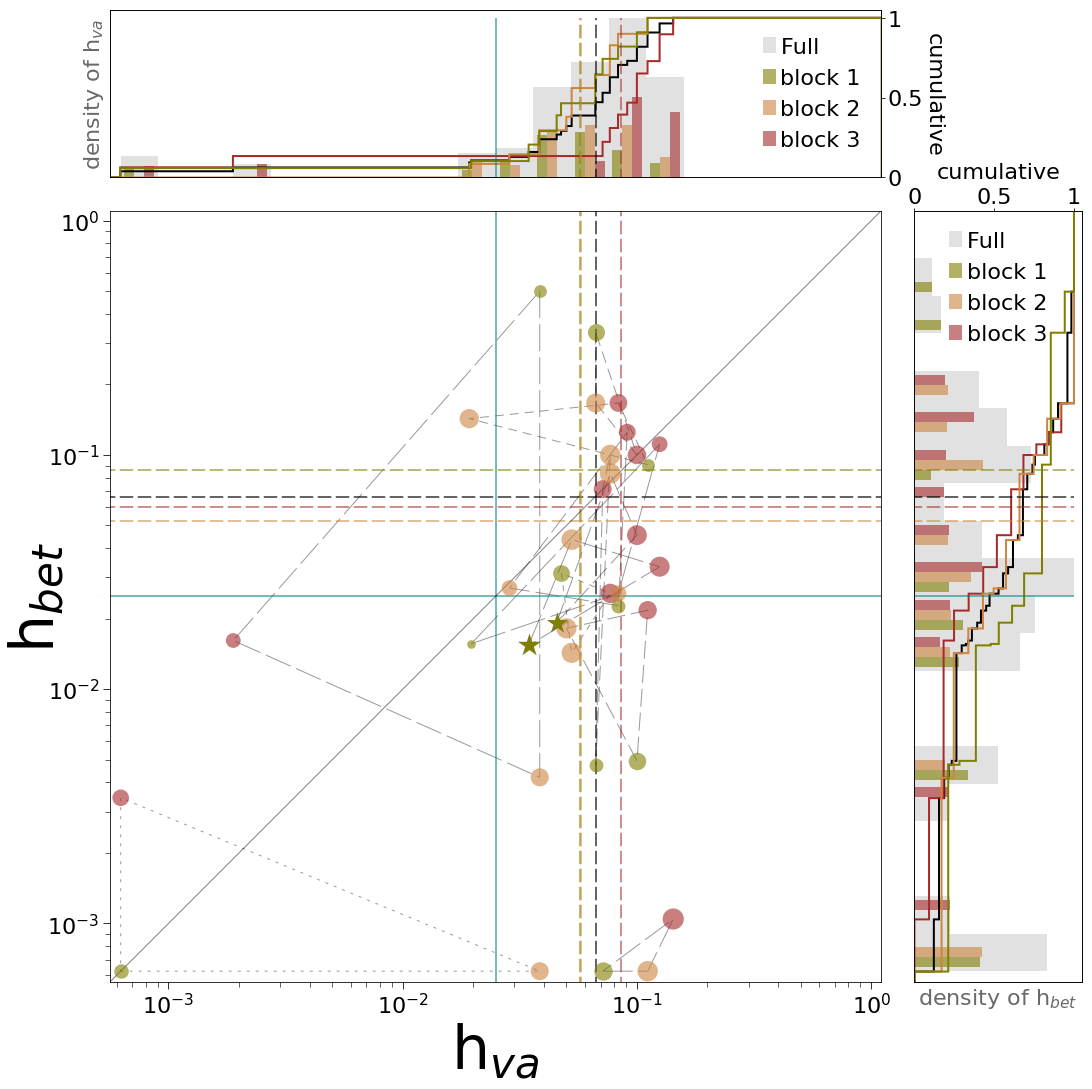



----------------------------------------------------------------
h_va
----------------------------------------------------------------
mean h_va 0.06693001293909086 +/- 0.03628249090005088
median h_va 0.06904761904761905
mean_pond h_va 0.07215164461380175

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
BLOCK 0 vs 1 :		0.4654		0.9078		0.9985
BLOCK 0 vs 2 :		0.0230		0.0429		0.0995
BLOCK 1 vs 2 :		0.0200		0.0373		0.0995

Significatif : ['B 0-2', 'B 1-2']


Coupe à h=0.002, tau=500
------------------------
mean h_va 0.07291939717087965 +/- 0.03171101679026716
median h_va 0.07142857142857142

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
BLOCK 0 vs 1 :		0.4145		0.8050		0.9992
BLOCK 0 vs 2 :		0.0024		0.0042		0.0112
BLOCK 1 vs 2 :		0.0008		0.0015		0.0067

Significatif : ['B 0-2', 'B 1-2']


Coupe à h=0.005, tau=200
------------------------
mean h_va 0.07291939717087965 +/- 0.03171101679026716
median h_va 0.07142857142857142

			mannwhitneyu	kruskal

In [12]:
fig = plot_fig(recording,  **opt)

AM BMC CS DC FM IP LB OP RS SR TN YK 

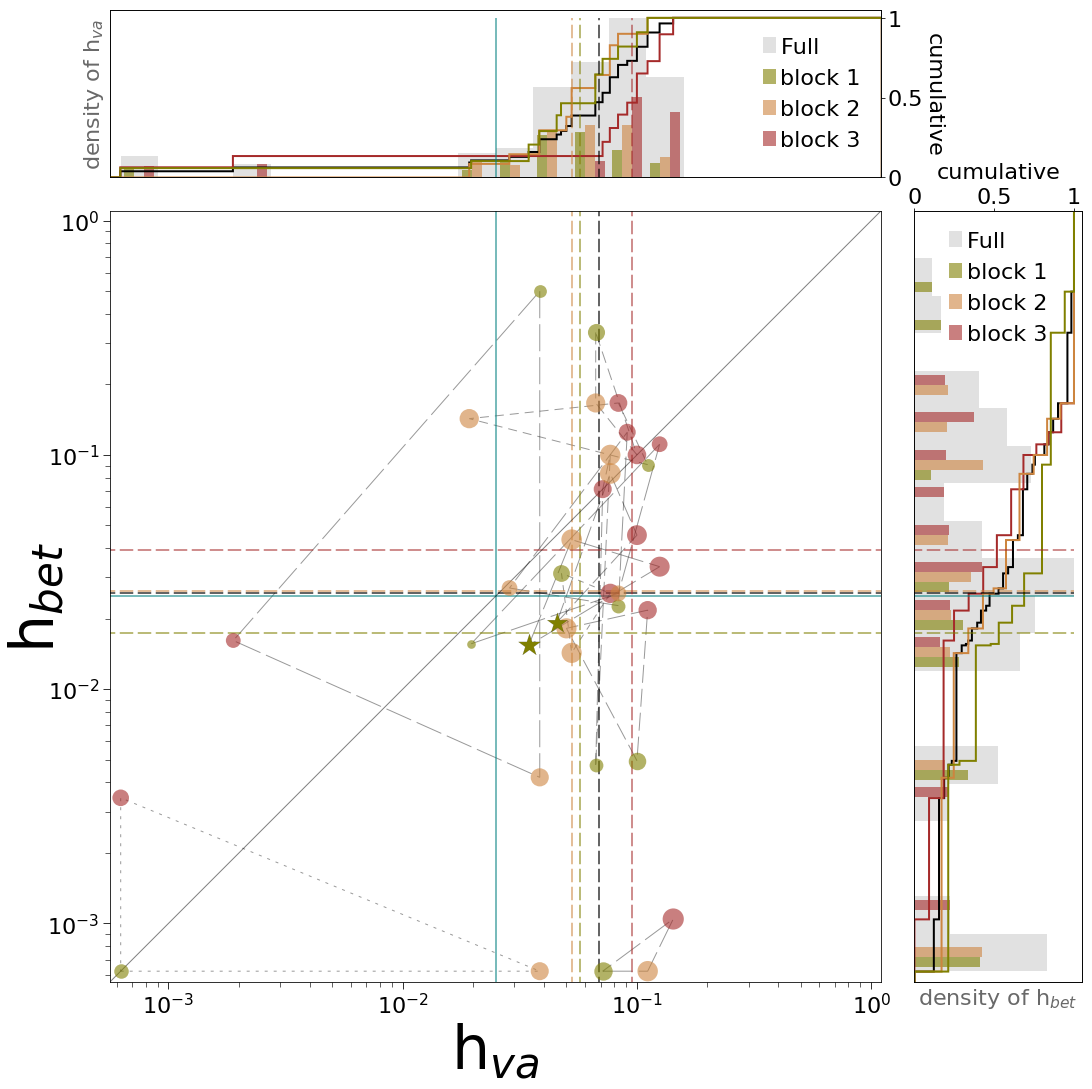



----------------------------------------------------------------
h_va
----------------------------------------------------------------
mean h_va 0.06693001293909086 +/- 0.03628249090005088
median h_va 0.06904761904761905
mean_pond h_va 0.07215164461380175

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
BLOCK 0 vs 1 :		0.4654		0.9078		0.9985
BLOCK 0 vs 2 :		0.0230		0.0429		0.0995
BLOCK 1 vs 2 :		0.0200		0.0373		0.0995

Significatif : ['B 0-2', 'B 1-2']


Coupe à h=0.002, tau=500
------------------------
mean h_va 0.07291939717087965 +/- 0.03171101679026716
median h_va 0.07142857142857142

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
BLOCK 0 vs 1 :		0.4145		0.8050		0.9992
BLOCK 0 vs 2 :		0.0024		0.0042		0.0112
BLOCK 1 vs 2 :		0.0008		0.0015		0.0067

Significatif : ['B 0-2', 'B 1-2']


Coupe à h=0.005, tau=200
------------------------
mean h_va 0.07291939717087965 +/- 0.03171101679026716
median h_va 0.07142857142857142

			mannwhitneyu	kruskal

In [13]:
fig = plot_fig(recording, mean='median', **opt)

AM BMC CS DC FM IP LB OP RS SR TN YK 

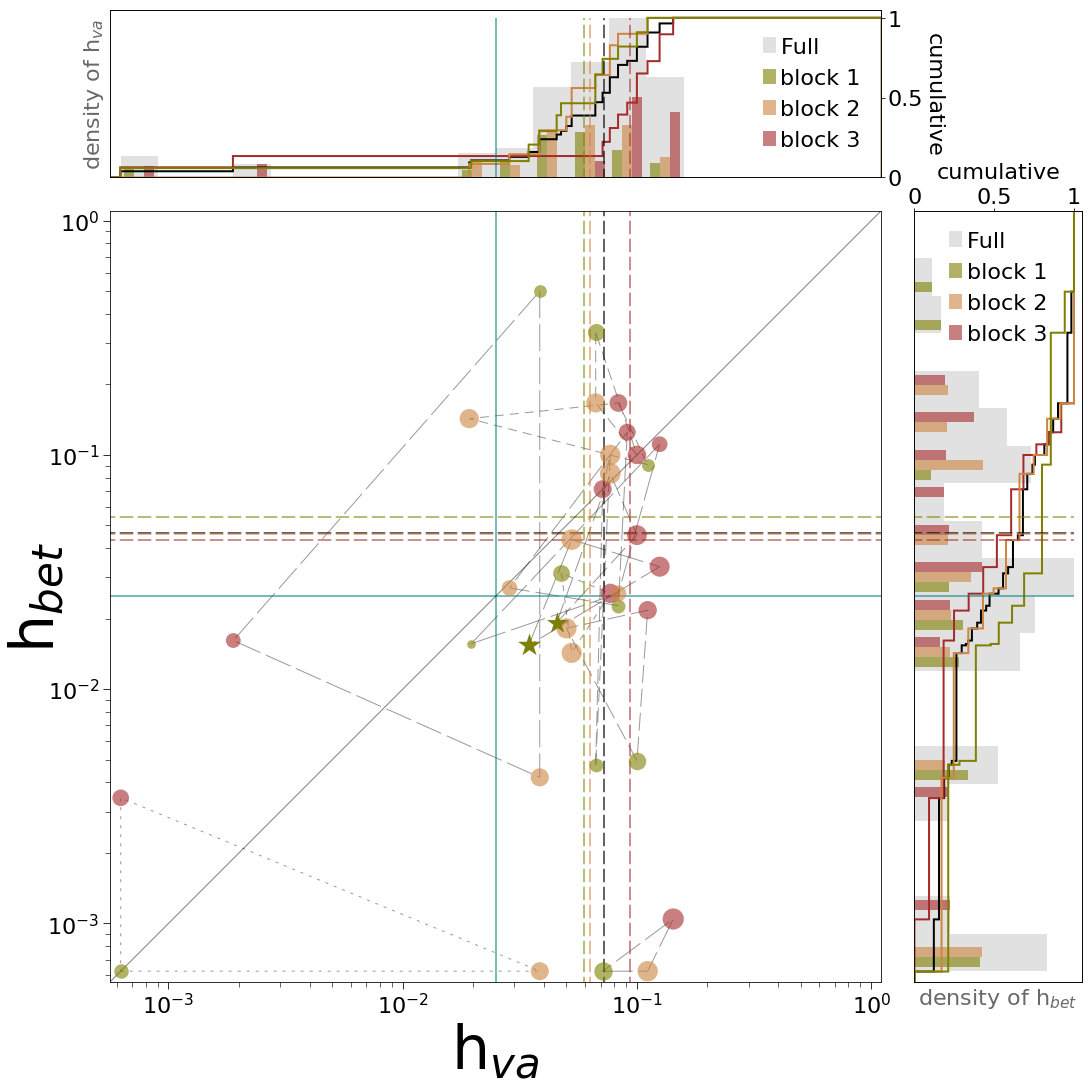



----------------------------------------------------------------
h_va
----------------------------------------------------------------
mean h_va 0.06693001293909086 +/- 0.03628249090005088
median h_va 0.06904761904761905
mean_pond h_va 0.07215164461380175

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
BLOCK 0 vs 1 :		0.4654		0.9078		0.9985
BLOCK 0 vs 2 :		0.0230		0.0429		0.0995
BLOCK 1 vs 2 :		0.0200		0.0373		0.0995

Significatif : ['B 0-2', 'B 1-2']


Coupe à h=0.002, tau=500
------------------------
mean h_va 0.07291939717087965 +/- 0.03171101679026716
median h_va 0.07142857142857142

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
BLOCK 0 vs 1 :		0.4145		0.8050		0.9992
BLOCK 0 vs 2 :		0.0024		0.0042		0.0112
BLOCK 1 vs 2 :		0.0008		0.0015		0.0067

Significatif : ['B 0-2', 'B 1-2']


Coupe à h=0.005, tau=200
------------------------
mean h_va 0.07291939717087965 +/- 0.03171101679026716
median h_va 0.07142857142857142

			mannwhitneyu	kruskal

In [14]:
fig = plot_fig(recording, mean='mean_pond', **opt)

---------------------------------